<a href="https://colab.research.google.com/github/RachelZhou287/542_Final/blob/main/BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
print(torchvision.__version__)
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
# ! pip install pyro-ppl
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine

0.23.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 18.6 MB/s eta 0:00:00


In [ ]:
# Test integrity first
!tar -tzf /content/CUB_200_2011.tgz > /dev/null


In [ ]:
# Extract safely
!mkdir -p /content/data
!tar -xzf /content/CUB_200_2011.tgz -C /content/data/

In [ ]:
# Confirm
!ls /content/data/CUB_200_2011 | head

attributes
bounding_boxes.txt
classes.txt
image_class_labels.txt
images
images.txt
parts
README
train_test_split.txt


# Load dataset

In [25]:

class CUBDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform

        img_files = pd.read_csv(os.path.join(root, "images.txt"), sep=" ", names=["img_id", "filepath"])
        labels = pd.read_csv(os.path.join(root, "image_class_labels.txt"), sep=" ", names=["img_id", "target"])
        split = pd.read_csv(os.path.join(root, "train_test_split.txt"), sep=" ", names=["img_id", "is_training_img"])
        df = img_files.merge(labels, on="img_id").merge(split, on="img_id")
        df = df[df["is_training_img"] == int(train)]

        self.paths = df["filepath"].values
        self.targets = df["target"].values - 1  # 0-indexed

    def __len__(self):  return len(self.paths) # number of samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.paths[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.targets[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# === Transforms + loaders ===
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

data_root = "/content/data/CUB_200_2011"
train_data = CUBDataset(data_root, train=True, transform=transform)
test_data  = CUBDataset(data_root, train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2) #batch size: group 32 images per training step
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Loaded {len(train_data)} training and {len(test_data)} testing images.")


✅ Loaded 5994 training and 5794 testing images.


# NN Structure

In [26]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Flatten 3×128×128 RGB images → [batch, 49152]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.out(x)  # raw logits (no softmax)
        return x


# Initialize network
input_size = 3 * 64 * 64
net = NN(input_size=input_size, hidden_size=128, output_size=200)

# Model

In [27]:
def model(x_data, y_data):
    # Normal(0,1) priors on all weights and biases
    fc1w_prior = Normal(torch.zeros_like(net.fc1.weight),
                        torch.ones_like(net.fc1.weight)).to_event(2)
    fc1b_prior = Normal(torch.zeros_like(net.fc1.bias),
                        torch.ones_like(net.fc1.bias)).to_event(1)
    outw_prior = Normal(torch.zeros_like(net.out.weight),
                        torch.ones_like(net.out.weight)).to_event(2)
    outb_prior = Normal(torch.zeros_like(net.out.bias),
                        torch.ones_like(net.out.bias)).to_event(1)

    priors = {
        'fc1.weight': fc1w_prior,
        'fc1.bias': fc1b_prior,
        'out.weight': outw_prior,
        'out.bias': outb_prior
    }

    lifted_model = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_model()  # one sample of network parameters

    # Forward pass
    logits = lifted_reg_model(x_data)

    # Each image is an independent observation
    with pyro.plate("data", x_data.size(0)):
        pyro.sample("obs", Categorical(logits=logits), obs=y_data)

# Guide

In [28]:
soft_plus = torch.nn.Softplus()

def guide(x_data, y_data):
    # Layer 1 weight posterior
    fc1w_mu = pyro.param("fc1w_mu", torch.randn_like(net.fc1.weight))
    fc1w_sigma_param = pyro.param("fc1w_sigma", torch.ones_like(net.fc1.weight))
    fc1w_sigma = soft_plus(fc1w_sigma_param)
    fc1w_dist = Normal(fc1w_mu, fc1w_sigma).to_event(2)

    # Layer 1 bias posterior
    fc1b_mu = pyro.param("fc1b_mu", torch.randn_like(net.fc1.bias))
    fc1b_sigma_param = pyro.param("fc1b_sigma", torch.ones_like(net.fc1.bias))
    fc1b_sigma = soft_plus(fc1b_sigma_param)
    fc1b_dist = Normal(fc1b_mu, fc1b_sigma).to_event(1)

    # Output layer weight posterior
    outw_mu = pyro.param("outw_mu", torch.randn_like(net.out.weight))
    outw_sigma_param = pyro.param("outw_sigma", torch.ones_like(net.out.weight))
    outw_sigma = soft_plus(outw_sigma_param)
    outw_dist = Normal(outw_mu, outw_sigma).to_event(2)

    # Output layer bias posterior
    outb_mu = pyro.param("outb_mu", torch.randn_like(net.out.bias))
    outb_sigma_param = pyro.param("outb_sigma", torch.ones_like(net.out.bias))
    outb_sigma = soft_plus(outb_sigma_param)
    outb_dist = Normal(outb_mu, outb_sigma).to_event(1)

    dists = {
        'fc1.weight': fc1w_dist,
        'fc1.bias': fc1b_dist,
        'out.weight': outw_dist,
        'out.bias': outb_dist
    }

    lifted_module = pyro.random_module("module", net, dists)
    return lifted_module()


# Posterior Samplying

In [29]:
@torch.no_grad()
def predict(x,K=10):
  sample_models=[guide[None,None] for _ in range(K)]
  yhats=[]
  for sample_nets in sample_models:
    logits=sample_nets(x.view(x.size(0), -1))
    yhats.append(F.softmax(logits,dim=1))
  yhats=torch.stack(yhats)  # [K, batch, num_classes]
  mean_probs=yhats.mean(0)
  var_probs=yhats.var(1)
  return mean_probs,var_probs

# Rejection Threshold

In [30]:
def test_batch(x , y, threshold=0.7):
  prob=predict(x)
  label=prob.argmax(1)
  maxProb=prob.max(1).values

  confident=maxProb > threshold
  correct=(label[confident]==y[confident]).sum().item()
  total=y.size(0)
  total_confident=confident.sum().item()

  if total_confident >0:
    acc=correct/total_confident

  refused=1-total_confident/total # proportion without a label

  return acc,refused

# Visualize Uncertainty

In [23]:
def visualize_uncertainty(x, num_samples=10):
    mean_probs, var_probs = predict(x[:num_samples])
    plt.figure(figsize=(10, 3))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(x[i].permute(1,2,0).numpy())
        plt.axis('off')
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.bar(range(mean_probs.shape[1]), mean_probs[i].numpy())
    plt.show()


# Train

✅ Loaded 5994 training and 5794 testing images.


/usr/local/lib/python3.12/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


Epoch 1/70 | β=1.00 | Avg ELBO loss: 230041.5010
Epoch 2/70 | β=1.00 | Avg ELBO loss: 211226.4914
Epoch 3/70 | β=1.00 | Avg ELBO loss: 192040.8000
Epoch 4/70 | β=1.00 | Avg ELBO loss: 172072.7236
Epoch 5/70 | β=1.00 | Avg ELBO loss: 152329.0981
Epoch 6/70 | β=1.00 | Avg ELBO loss: 133414.1877
Epoch 7/70 | β=1.00 | Avg ELBO loss: 115841.5277
Epoch 8/70 | β=1.00 | Avg ELBO loss: 99711.4589
Epoch 9/70 | β=1.00 | Avg ELBO loss: 85213.0430
Epoch 10/70 | β=1.00 | Avg ELBO loss: 72263.5031
Epoch 11/70 | β=1.00 | Avg ELBO loss: 60812.8476
Epoch 12/70 | β=1.00 | Avg ELBO loss: 50838.7088
Epoch 13/70 | β=1.00 | Avg ELBO loss: 42222.8957
Epoch 14/70 | β=1.00 | Avg ELBO loss: 34828.1315
Epoch 15/70 | β=1.00 | Avg ELBO loss: 28557.8140
Epoch 16/70 | β=1.00 | Avg ELBO loss: 23274.0018
Epoch 17/70 | β=1.00 | Avg ELBO loss: 18846.1538
Epoch 18/70 | β=1.00 | Avg ELBO loss: 15182.5682
Epoch 19/70 | β=1.00 | Avg ELBO loss: 12165.1483
Epoch 20/70 | β=1.00 | Avg ELBO loss: 9702.4874
Epoch 21/70 | β=1.00 | 

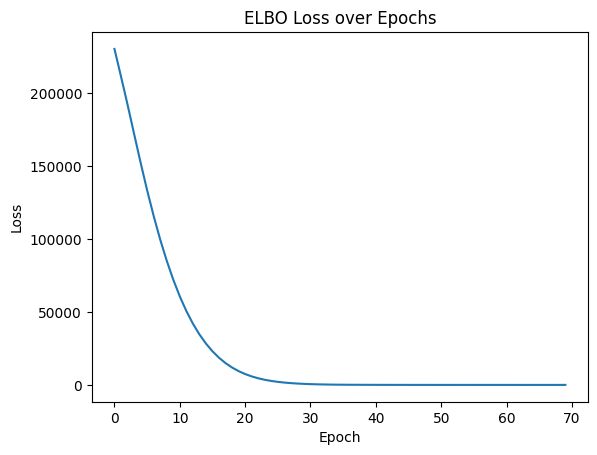

In [35]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# ============================================================
# 1️⃣ Dataset Definition
# ============================================================

class CUBDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform

        img_files = pd.read_csv(os.path.join(root, "images.txt"), sep=" ", names=["img_id", "filepath"])
        labels = pd.read_csv(os.path.join(root, "image_class_labels.txt"), sep=" ", names=["img_id", "target"])
        split = pd.read_csv(os.path.join(root, "train_test_split.txt"), sep=" ", names=["img_id", "is_training_img"])
        df = img_files.merge(labels, on="img_id").merge(split, on="img_id")
        df = df[df["is_training_img"] == int(train)]

        self.paths = df["filepath"].values
        self.targets = df["target"].values - 1  # convert to 0-based

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.paths[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.targets[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


# ============================================================
# 2️⃣ Simple Neural Network (for Bayesian wrapping)
# ============================================================

class SimpleNN(nn.Module):
    def __init__(self, input_size=3*128*128, hidden_size=256, output_size=200):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x


# ============================================================
# 3️⃣ Model and Guide for Bayesian Training
# ============================================================

soft_plus = nn.Softplus()

def model(x_data, y_data):
    fc1w_prior = Normal(torch.zeros_like(net.fc1.weight), torch.ones_like(net.fc1.weight)).to_event(2)
    fc1b_prior = Normal(torch.zeros_like(net.fc1.bias), torch.ones_like(net.fc1.bias)).to_event(1)
    outw_prior = Normal(torch.zeros_like(net.out.weight), torch.ones_like(net.out.weight)).to_event(2)
    outb_prior = Normal(torch.zeros_like(net.out.bias), torch.ones_like(net.out.bias)).to_event(1)

    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
              'out.weight': outw_prior, 'out.bias': outb_prior}

    lifted_net = pyro.random_module("module", net, priors)
    sampled_net = lifted_net()

    with pyro.plate("data", x_data.size(0)):
        logits = sampled_net(x_data)
        pyro.sample("obs", Categorical(logits=logits), obs=y_data)


def guide(x_data, y_data):
    # mean and std for each parameter
    fc1w_mu = pyro.param("fc1w_mu", torch.randn_like(net.fc1.weight))
    fc1w_sigma = soft_plus(pyro.param("fc1w_sigma", torch.ones_like(net.fc1.weight)))

    fc1b_mu = pyro.param("fc1b_mu", torch.randn_like(net.fc1.bias))
    fc1b_sigma = soft_plus(pyro.param("fc1b_sigma", torch.ones_like(net.fc1.bias)))

    outw_mu = pyro.param("outw_mu", torch.randn_like(net.out.weight))
    outw_sigma = soft_plus(pyro.param("outw_sigma", torch.ones_like(net.out.weight)))

    outb_mu = pyro.param("outb_mu", torch.randn_like(net.out.bias))
    outb_sigma = soft_plus(pyro.param("outb_sigma", torch.ones_like(net.out.bias)))

    dists = {
        "fc1.weight": Normal(fc1w_mu, fc1w_sigma).to_event(2),
        "fc1.bias": Normal(fc1b_mu, fc1b_sigma).to_event(1),
        "out.weight": Normal(outw_mu, outw_sigma).to_event(2),
        "out.bias": Normal(outb_mu, outb_sigma).to_event(1),
    }

    lifted_net = pyro.random_module("module", net, dists)
    return lifted_net()


# ============================================================
# 4️⃣ Prediction and Evaluation
# ============================================================

@torch.no_grad()
def predict(x, K=10):
    sampled_models = [guide(None, None) for _ in range(K)]
    yhats = []
    for sampled_net in sampled_models:
        logits = sampled_net(x.view(x.size(0), -1))
        yhats.append(F.softmax(logits, dim=1))
    yhats = torch.stack(yhats)
    mean_probs = yhats.mean(0)
    var_probs = yhats.var(0)
    return mean_probs, var_probs


@torch.no_grad()
def evaluate(loader, threshold=0.5):
    correct, total, confident_total = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        mean_probs, _ = predict(imgs)
        preds = mean_probs.argmax(1)
        conf = mean_probs.max(1).values
        confident_mask = conf > threshold
        correct += (preds[confident_mask] == labels[confident_mask]).sum().item()
        confident_total += confident_mask.sum().item()
        total += labels.size(0)

    acc = correct / confident_total if confident_total > 0 else 0
    skip_rate = 1 - confident_total / total
    return acc, skip_rate


# ============================================================
# 5️⃣ Training Loop
# ============================================================

def train_bnn(num_epochs=5, beta=0.5):
    pyro.clear_param_store()
    svi = SVI(model, guide, Adam({"lr": 1e-3}), loss=Trace_ELBO())

    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Standard ELBO step
            elbo = svi.step(imgs, labels)

            # Apply β coefficient manually (optional annealing)
            total_loss += beta * elbo

        avg_loss = total_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | β={beta:.2f} | Avg ELBO loss: {avg_loss:.4f}")

    return loss_history



# ============================================================
# 6️⃣ Main Script
# ============================================================

if __name__ == "__main__":
    data_root = "/content/data/CUB_200_2011"

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    train_data = CUBDataset(data_root, train=True, transform=transform)
    test_data = CUBDataset(data_root, train=False, transform=transform)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

    print(f"✅ Loaded {len(train_data)} training and {len(test_data)} testing images.")

    # setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = SimpleNN().to(device)

    # === Train ===
    loss_hist = train_bnn(num_epochs=70, beta=1)

    # === Evaluate ===
    acc, skip = evaluate(test_loader, threshold=0.1)
    print(f"Accuracy (when predicted): {acc*100:.2f}% | Skip rate: {skip*100:.2f}%")

    # === Plot loss ===
    plt.plot(loss_hist)
    plt.title("ELBO Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
